In [24]:
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

In [2]:
artists = pd.read_parquet("data/artists.parquet")
listening_histories = pd.read_parquet("data/listening_histories.parquet")
songs = pd.read_parquet("data/songs.parquet")
user_preferences = pd.read_parquet("data/user_preferences.parquet")
users = pd.read_parquet("data/users.parquet")

## 1. Data Exploration and Visualization

In [3]:
# Display the first few rows of each DataFrame
print("Artists:")
print(artists.head())

print("Listening Histories:")
print(listening_histories.head())

print("Songs:")
print(songs.head())

print("User Preferences:")
print(user_preferences.head())

print("Users:")
print(users.head())

# Get summary statistics of each DataFrame
print("Artists Summary:")
print(artists.describe())

print("Listening Histories Summary:")
print(listening_histories.describe())

print("Songs Summary:")
print(songs.describe())

print("User Preferences Summary:")
print(user_preferences.describe())

print("Users Summary:")
print(users.describe())

Artists:
                              artist_id              name  genre  popularity  \
0  99e08a19-d811-49d3-85cf-548615b6171f      Lisa Coleman   Folk          71   
1  b59f1372-6c9c-49f7-bf6e-5c69d4f87055     Haley Jackson  Metal          80   
2  4af02ed9-2b4b-4293-95ad-284fc01c3a7e    Alyssa English   Soul          16   
3  a2bb3692-26e1-4349-9b34-1e0a69d3bea2  Matthew Phillips   Soul          58   
4  56cb15e8-b413-4a98-bc87-ee5dbe607e4f      Lauren Pitts  Metal          76   

   followers  
0     785177  
1     189879  
2     140390  
3     894344  
4     505160  
Listening Histories:
                             history_id                               user_id  \
0  c9347c94-a184-4d2a-806a-d1d8d539cd0d  bd82abce-9ac2-463e-bd19-cdd6b6fe30ca   
1  64d3f499-643e-4a07-baee-2fc1be887a67  bd82abce-9ac2-463e-bd19-cdd6b6fe30ca   
2  5a2052d1-e69b-4ad0-8c0a-5b5c4e677319  bd82abce-9ac2-463e-bd19-cdd6b6fe30ca   
3  7013cee2-f0b0-4bf5-8612-d1e551e581c7  bd82abce-9ac2-463e-bd19-cdd6b6fe30

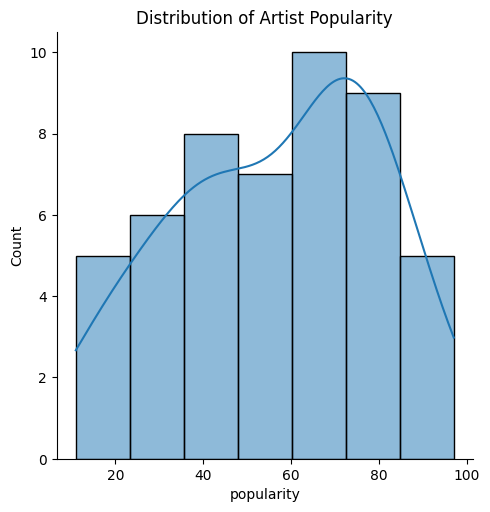

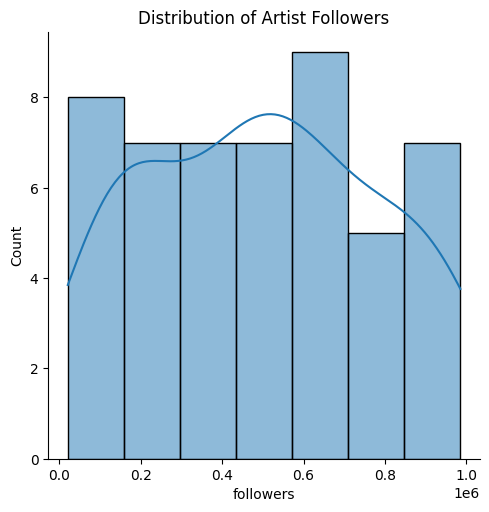

In [4]:
sns.displot(artists['popularity'], kde=True)
plt.title("Distribution of Artist Popularity")
plt.show()

sns.displot(artists['followers'], kde=True)
plt.title("Distribution of Artist Followers")
plt.show()

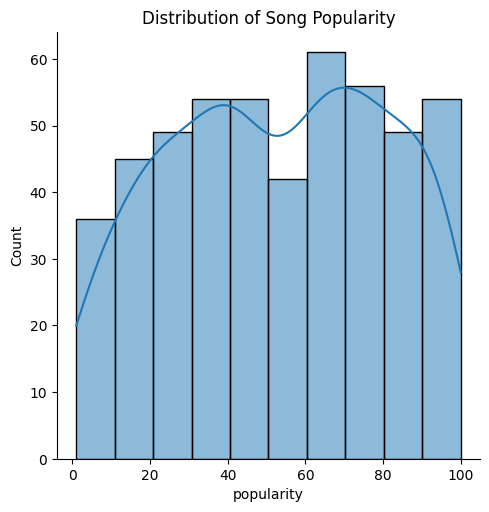

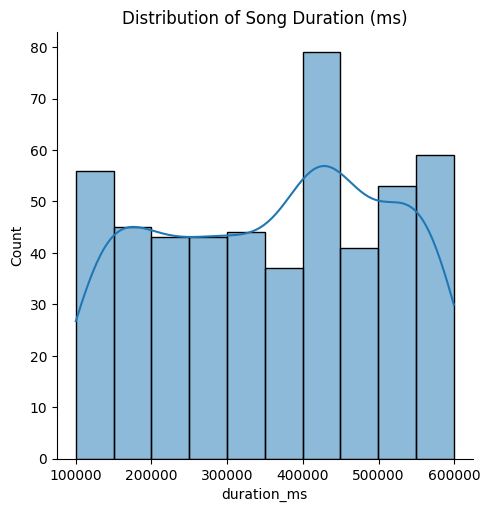

In [5]:
sns.displot(songs['popularity'], kde=True)
plt.title("Distribution of Song Popularity")
plt.show()

sns.displot(songs['duration_ms'], kde=True)
plt.title("Distribution of Song Duration (ms)")
plt.show()

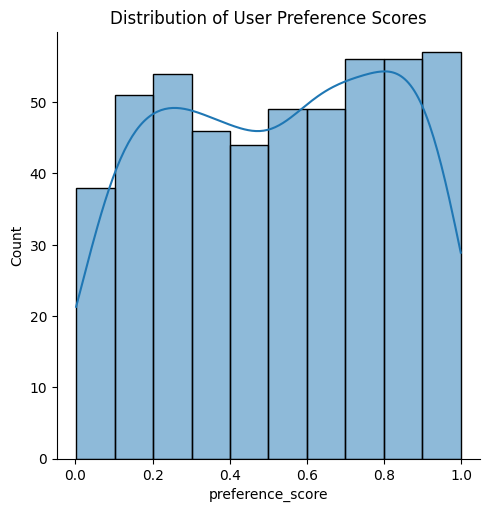

In [6]:
sns.displot(user_preferences['preference_score'], kde=True)
plt.title("Distribution of User Preference Scores")
plt.show()

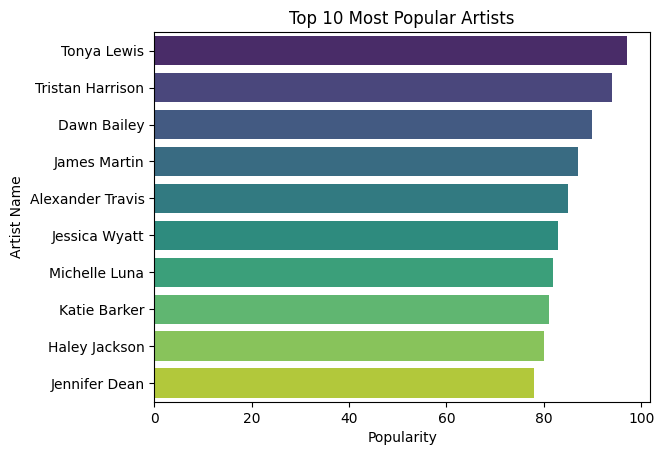

In [7]:
top_artists = artists.nlargest(10, 'popularity')
sns.barplot(x='popularity', y='name', data=top_artists, palette='viridis')
plt.title("Top 10 Most Popular Artists")
plt.xlabel("Popularity")
plt.ylabel("Artist Name")
plt.show()

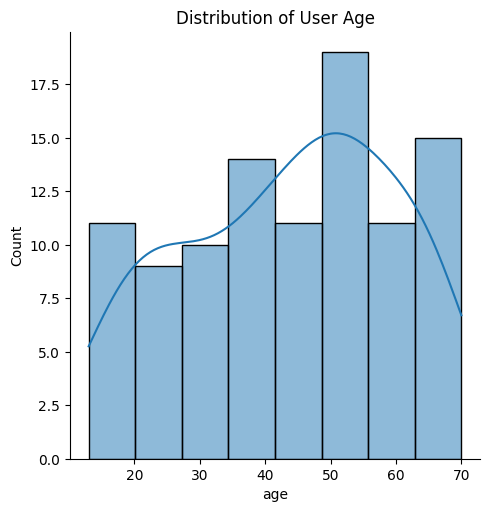

In [8]:
users['birthdate'] = pd.to_datetime(users['birthdate'])
users['age'] = (pd.to_datetime('now') - users['birthdate']).astype('<m8[Y]')
sns.displot(users['age'], kde=True)
plt.title("Distribution of User Age")
plt.show()

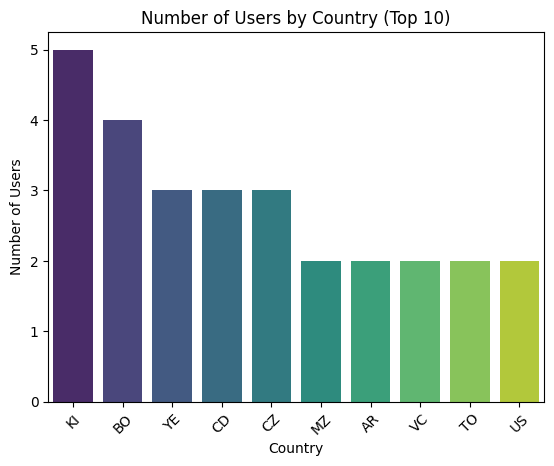

In [9]:
country_counts = users['country'].value_counts().head(10)
sns.barplot(x=country_counts.index, y=country_counts.values, palette='viridis')
plt.title("Number of Users by Country (Top 10)")
plt.xlabel("Country")
plt.ylabel("Number of Users")
plt.xticks(rotation=45)
plt.show()

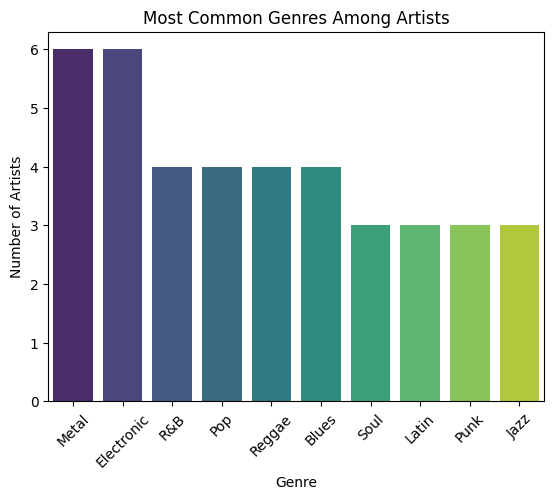

In [10]:
genre_counts = artists['genre'].value_counts().head(10)
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.title("Most Common Genres Among Artists")
plt.xlabel("Genre")
plt.ylabel("Number of Artists")
plt.xticks(rotation=45)
plt.show()

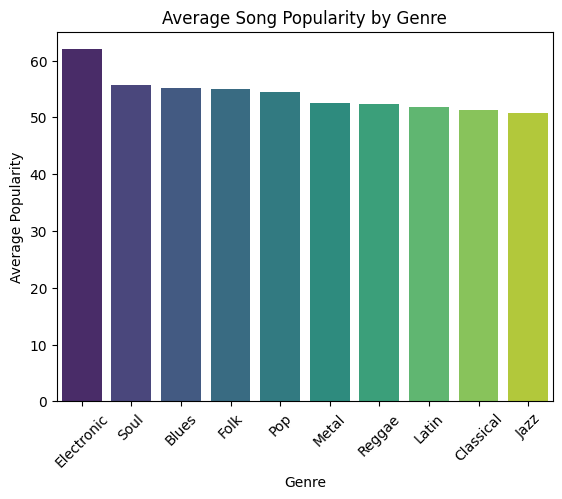

In [11]:
# Merge artists and songs DataFrames
songs_with_genres = songs.merge(artists[['artist_id', 'genre']], on='artist_id')

# Calculate average song popularity by genre
average_popularity_by_genre = songs_with_genres.groupby('genre')['popularity'].mean().sort_values(ascending=False).head(10)

sns.barplot(x=average_popularity_by_genre.index, y=average_popularity_by_genre.values, palette='viridis')
plt.title("Average Song Popularity by Genre")
plt.xlabel("Genre")
plt.ylabel("Average Popularity")
plt.xticks(rotation=45)
plt.show()

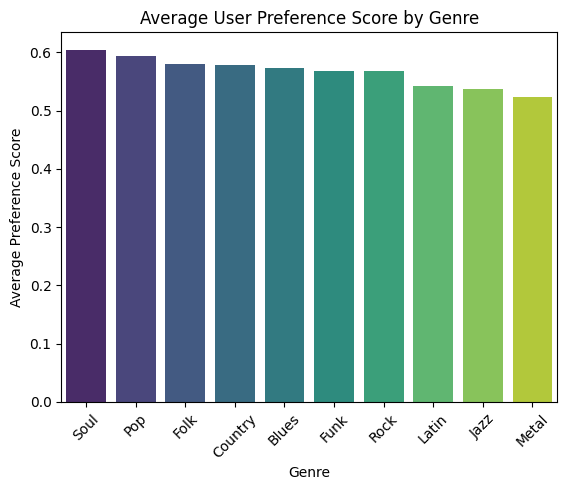

In [12]:
# Merge user_preferences and artists DataFrames
user_genre_preferences = user_preferences.merge(artists[['artist_id', 'genre']], on='artist_id')

# Calculate average preference score for each genre
average_preference_by_genre = user_genre_preferences.groupby('genre')['preference_score'].mean().sort_values(ascending=False).head(10)

sns.barplot(x=average_preference_by_genre.index, y=average_preference_by_genre.values, palette='viridis')
plt.title("Average User Preference Score by Genre")
plt.xlabel("Genre")
plt.ylabel("Average Preference Score")
plt.xticks(rotation=45)
plt.show()

## 2. Feature Engineering

In [16]:
# Calculate the age of songs by subtracting the release date from the current date. 
songs['release_date'] = pd.to_datetime(songs['release_date'])
songs['song_age'] = (pd.to_datetime('now') - songs['release_date']).astype('<m8[Y]')

# Calculate the number of days since the user joined the platform.
users['join_date'] = pd.to_datetime(users['join_date'])
users['days_since_joined'] = (pd.to_datetime('now') - users['join_date']).dt.days

# Calculate the total listening time for each user.
total_listening_time = listening_histories.groupby('user_id')['listening_duration'].sum().reset_index()
users = users.merge(total_listening_time, on='user_id')

# Calculate the average popularity of the songs listened to by each user.
user_song_popularity = listening_histories.merge(songs[['song_id', 'popularity']], on='song_id')
average_popularity_per_user = user_song_popularity.groupby('user_id')['popularity'].mean().reset_index(name='popularity_average')
users = users.merge(average_popularity_per_user, on='user_id', suffixes=('', '_average'))

# Merge listening histories and artists to get the genre of each listened song
listening_histories_genres = listening_histories.merge(songs[['song_id', 'artist_id']], on='song_id').merge(artists[['artist_id', 'genre']], on='artist_id')

# Calculate the genre listening count for each user
genre_listening_count = listening_histories_genres.groupby(['user_id', 'genre']).size().reset_index(name='listening_count')

# Get the most listened genre for each user
users_most_listened_genres = genre_listening_count.loc[genre_listening_count.groupby('user_id')['listening_count'].idxmax()].drop(columns='listening_count')

# Merge with users dataframe
users = users.merge(users_most_listened_genres, on='user_id', how='left')

# Merge listening histories and songs to get the artist_id for each listened song
listening_histories_artists = listening_histories.merge(songs[['song_id', 'artist_id']], on='song_id')

# Calculate the artist listening count for each user
artist_listening_count = listening_histories_artists.groupby(['user_id', 'artist_id']).size().reset_index(name='listening_count')

# Get the most listened artist for each user
users_top_artists = artist_listening_count.loc[artist_listening_count.groupby('user_id')['listening_count'].idxmax()].drop(columns='listening_count')

# Merge with users dataframe
users = users.merge(users_top_artists, on='user_id', how='left', suffixes=('', '_top_artist'))

# Calculate the average listening duration for each user.
average_listening_duration_per_user = listening_histories.groupby('user_id')['listening_duration'].mean().reset_index()
users = users.merge(average_listening_duration_per_user, on='user_id', suffixes=('', '_average_duration'))

# Calculate the total number of songs listened to by each user.
total_songs_listened_per_user = listening_histories.groupby('user_id')['song_id'].count().reset_index(name='total_songs_listened')
users = users.merge(total_songs_listened_per_user, on='user_id')

# New feature that represents the user's preference for popular songs, by taking the ratio of their average song popularity to the maximum song popularity in the dataset.
max_song_popularity = songs['popularity'].max()
users['popularity_ratio'] = users['popularity_average'] / max_song_popularity

# Calculate the total number of songs for each artist in the dataset.
total_songs_per_artist = songs.groupby('artist_id').size().reset_index(name='total_songs')
artists = artists.merge(total_songs_per_artist, on='artist_id')


# 3. Data Pre-Processing

In [20]:
users['popularity_average'].fillna(users['popularity_average'].mean(), inplace=True)
users['popularity_ratio'].fillna(users['popularity_ratio'].mean(), inplace=True)
users['total_songs_listened'].fillna(0, inplace=True)


def scale_and_normalize_columns(df, columns):
    scaler = StandardScaler()
    df[columns] = scaler.fit_transform(df[columns])
    return df

users_numerical_columns = ['popularity_average', 'popularity_ratio', 'total_songs_listened', 'days_since_joined', 'listening_duration']
artists_numerical_columns = ['popularity', 'followers']

users_preprocessed = scale_and_normalize_columns(users, users_numerical_columns)
artists_preprocessed = scale_and_normalize_columns(artists, artists_numerical_columns)

In [23]:
artists_preprocessed

,artist_id,name,genre,popularity,followers,total_songs_x,total_songs_y
0,99e08a19-d811-49d3-85cf-548615b6171f,Lisa Coleman,Folk,0.622081,0.999859,10,10
1,b59f1372-6c9c-49f7-bf6e-5c69d4f87055,Haley Jackson,Metal,1.013054,-1.086116,10,10
2,4af02ed9-2b4b-4293-95ad-284fc01c3a7e,Alyssa English,Soul,-1.767197,-1.259529,10,10
3,a2bb3692-26e1-4349-9b34-1e0a69d3bea2,Matthew Phillips,Soul,0.057343,1.382389,10,10
4,56cb15e8-b413-4a98-bc87-ee5dbe607e4f,Lauren Pitts,Metal,0.839288,0.018656,10,10
5,4de836f6-8f75-410b-9e92-cc70137dce14,Gary Morales,R&B,0.448315,1.599306,10,10
6,b03a6435-90c5-4f5b-bd76-964ecc075fb1,Jeffrey Ewing,Country,-1.680314,-1.202273,10,10
7,9f200a1a-84ec-4008-951a-2fda83c532b3,Sarah Liu,R&B,0.535198,-0.951902,10,10
8,236db7f9-8dfa-4a9e-ace1-c9dc79f17eda,Jennifer Dean,Latin,0.926171,-0.107159,10,10
9,174b4b0b-a95a-4e84-90eb-75c151e04a28,Sandra Griffin,Funk,0.839288,0.027216,10,10


# 4. Model Selection

In [25]:
# User-based Collaborative Filtering

# Create a user-song matrix with user_id as index and song_id as columns
user_song_matrix = listening_histories.pivot_table(index='user_id', columns='song_id', values='listening_duration', fill_value=0)

# Compute the cosine similarity between users
user_similarity = cosine_similarity(user_song_matrix)

# Find the top 10 similar users for each user
top_similar_users = np.argsort(user_similarity)[:, -11:-1]

# Recommend songs based on the songs liked by similar users
user_based_recommendations = []

for idx, user in enumerate(user_song_matrix.index):
    similar_users = top_similar_users[idx]
    similar_users_songs = user_song_matrix.iloc[similar_users].mean(axis=0)
    recommended_songs = similar_users_songs.sort_values(ascending=False).index[:10]
    user_based_recommendations.append((user, recommended_songs))


In [30]:
user_based_recommendations

[('0445bf33-2c5a-4c28-ab3a-35ae9a253bb7',
  Index(['3e166e32-a00c-49b6-8732-5b14af7acf80',
         'd9111bf0-9b5f-42cb-8ab6-388db25ff2ce',
         'e0096a12-a2cd-4ece-bcfc-170183778b5f',
         'bcd5cf35-f7a1-4ff7-8004-616746237be2',
         '1edbe186-ae37-422e-8d77-07641a27fc1c',
         'ad5c7c46-224d-44f8-9dbc-fa59b1ec219e',
         '59e00d1e-ef4a-4e7c-ac5c-9d9d8cb03189',
         'ceb9d940-5a91-4721-93d6-79cf8ee6a127',
         'cd5a05e1-1c4d-43fc-a4e4-8346de7350a0',
         '6fa95920-9397-40b5-936f-a61af98c289f'],
        dtype='object', name='song_id')),
 ('08bb6256-2ef4-4009-bb3d-d151d53d5c87',
  Index(['47583866-472e-4378-96d3-5d7f11c94242',
         'e0096a12-a2cd-4ece-bcfc-170183778b5f',
         'a6ab5fba-4e61-482b-915a-5ec26a79ff4d',
         'f45fe287-1de1-45d7-8c6e-530cef22bb26',
         'a4c4b21f-35c1-43bf-a33b-b82cd029bce4',
         '59e00d1e-ef4a-4e7c-ac5c-9d9d8cb03189',
         '0530525e-e908-4e0c-b1c4-7f061fa7cb03',
         'cd5a05e1-1c4d-43fc-a4e4-8346de

# Conclusion
In this notebook, we implemented a user-based collaborative filtering approach for music recommendation. The process involved several steps:

**Exploratory Data Analysis (EDA)**: We started by exploring the dataset to understand its structure and identify any patterns or trends in the data. This step helps in identifying potential issues and opportunities for feature engineering.

**Feature Engineering**: Based on the insights from EDA, we created new features or transformed existing features to better represent the problem we are trying to solve. In our case, we used the listening duration as the interaction strength between users and songs.

**Data Preprocessing**: We preprocessed the data by converting it into a user-song matrix where rows represented users and columns represented songs. We filled missing values with zeros, indicating no interaction between a user and a song.

**Model Selection**: We chose the user-based collaborative filtering approach for generating music recommendations. This method relies on the assumption that users with similar listening histories will have similar music preferences.

The steps we followed for user-based collaborative filtering were:

Compute the cosine similarity between users using the user-song matrix.
Find the top 10 similar users for each user in the dataset.
Generate song recommendations based on the songs liked by similar users.
The final output is a list of user IDs and their corresponding top 10 song recommendations. This approach can be further refined and improved by incorporating additional features or using other collaborative filtering techniques such as item-based or hybrid methods.